# Prerequisites

In [1]:
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import display
from skimage.morphology import binary_erosion
from tqdm.notebook import tqdm

from dataset import (
    HWSetNoise,
    get_dloader,
    normalize_hw,
    normalize_hw_mask,
    normalize_inv_hw,
    normalize_inv_hw_mask,
    transform_shared,
)
from dataset3d import BNSetNoise, get_dloader_noise
from util import show_imarray
from util3d import show_volume

# sns.set_theme()

In [3]:
data_dir = "../data"
fig_dir = "../figures"

class_legend = ("Siberian Husky", "Grey Wolf")

# Data

## Husky vs. Wolf

### Statistics

In [5]:
trainset = HWSetNoise(data_dir, "train")
valset = HWSetNoise(data_dir, "val")
testset = HWSetNoise(data_dir, "test")

In [6]:
len(trainset), len(valset), len(testset)

(932, 100, 629)

In [7]:
total = len(trainset) + len(valset) + len(testset)
total, len(trainset) / total, len(valset) / total, len(testset) / total

(1661, 0.5611077664057796, 0.060204695966285374, 0.378687537627935)

In [8]:
trainset.labels.sum(), valset.labels.sum(), testset.labels.sum()

(466, 50, 306)

In [9]:
trainset.labels.sum() / len(trainset), valset.labels.sum() / len(
    valset
), testset.labels.sum() / len(testset)

(0.5, 0.5, 0.4864864864864865)

In [10]:
sizes = {"train": [], "val": []}
dsets = {"train": trainset, "val": valset}
for k, dset in (("train", trainset), ("val", valset)):
    for item in tqdm(range(len(dset))):
        img, label, mask, _ = dset[item]
        sizes[k].append(np.array(mask).astype(bool).sum() / (mask.size[0] * mask.size[1]))

for k in sizes:
    sizes[k] = np.array(sizes[k])

  0%|          | 0/932 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train
0.30773599561676496


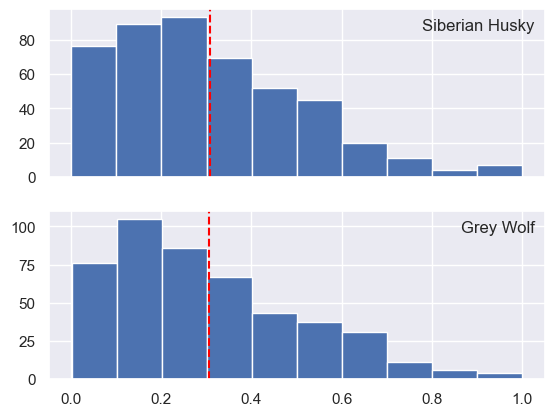

In [11]:
sns.set_theme()

for k, s in sizes.items():
    print(k)
    print(s.mean())

    fig, axs = plt.subplots(2, 1, sharex=True)
    for i in range(2):
        # print(s[dsets[k].labels == i].mean())
        hist, bins = np.histogram(s[dsets[k].labels == i], bins=10)
        # logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
        logbins = bins
        axs[i].hist(s[dsets[k].labels == i], bins=logbins)
        axs[i].axvline(s[dsets[k].labels == i].mean(), ls="--", c="red")
        axs[i].set_title(class_legend[i], x=0.98, y=0.825, loc="right")
        # axs[i].set_xscale("log")
    plt.savefig(f"{fig_dir}/hw_size_hist.pdf", bbox_inches='tight')
    plt.show()
    break

### Samples

In [12]:
dloader = get_dloader("val", batch_size=1, data_dir=data_dir, noise=True, num_workers=0)
# dloader_iter = iter(dloader)

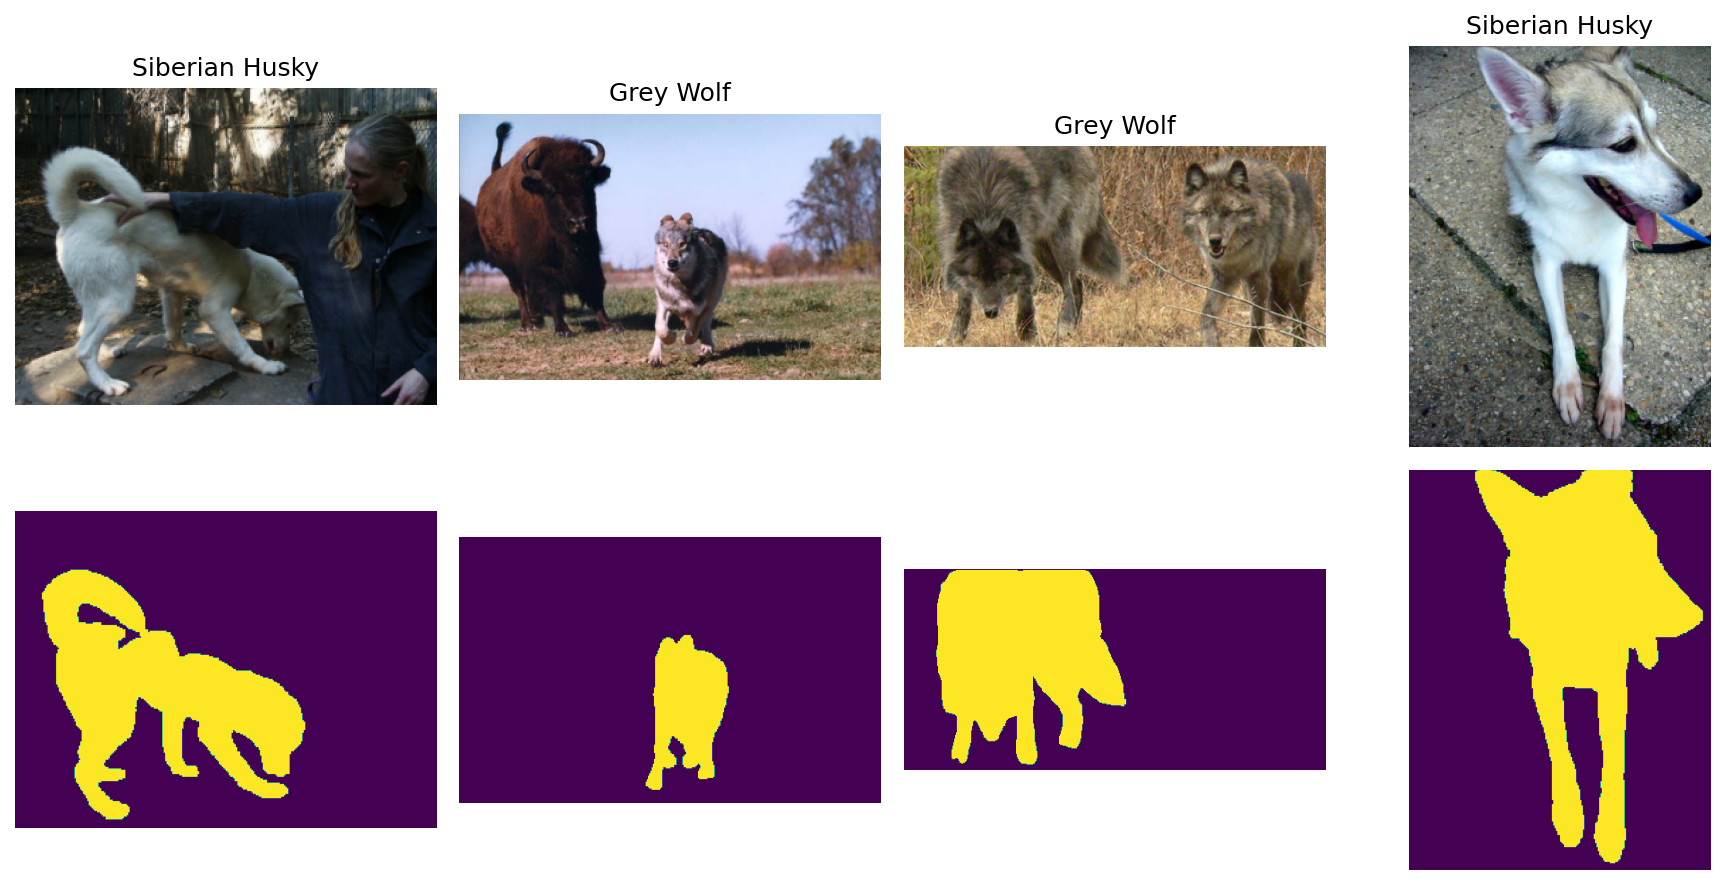

In [13]:
sns.reset_orig()

dloader_iter = iter(dloader)

n = 4
size = 3

fig, (axs_img, axs_mask) = plt.subplots(
    2, n, figsize=(size * n, size * 2), tight_layout=True, dpi=150
)
for i, (ax_img, ax_mask) in enumerate(zip(axs_img, axs_mask)):
    imgs, labels, masks, noise = next(dloader_iter)

    ax_img.set_title(class_legend[labels.item()])
    show_imarray(imgs[0], ax=ax_img)
    show_imarray(masks[0], ax=ax_mask)

    ax_img.axis("off")
    ax_mask.axis("off")
plt.savefig(f"{fig_dir}/hw_samples_segmentation.pdf", bbox_inches='tight')
plt.show()

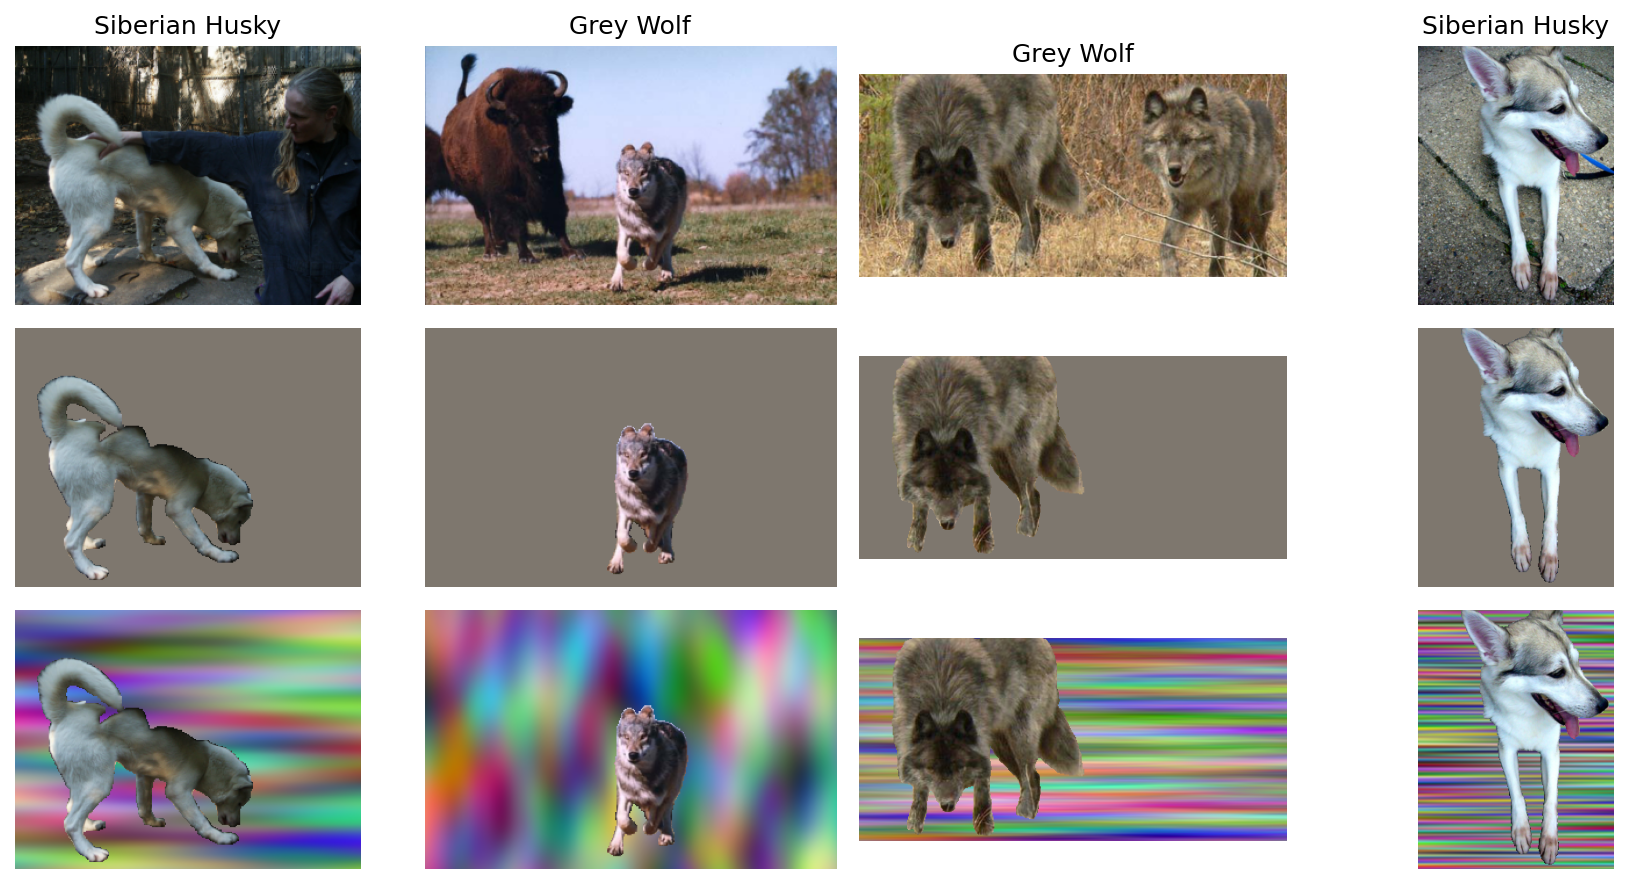

In [14]:
dloader_iter = iter(dloader)

n = 4
size = 3

fig, (axs_img, axs_mask, axs_noise) = plt.subplots(
    3, n, figsize=((size) * n, size * 2), tight_layout=True, dpi=150
)
for i, (ax_img, ax_mask, ax_noise) in enumerate(zip(axs_img, axs_mask, axs_noise)):
    imgs, labels, masks, noise = next(dloader_iter)

    ax_img.set_title(class_legend[labels.item()])
    show_imarray(imgs, ax=ax_img)
    show_imarray(normalize_inv_hw_mask(normalize_hw_mask(imgs) * masks), ax=ax_mask)
    show_imarray(imgs * masks + noise * (~masks), ax=ax_noise)

    ax_img.axis("off")
    ax_mask.axis("off")
    ax_noise.axis("off")
plt.savefig(f"{fig_dir}/hw_samples_abc.pdf", bbox_inches='tight')
plt.show()

## BugNIST

In [15]:
bn_data_dir = f"{data_dir}/BugNIST_DATA"
name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

### Statistics

In [16]:
trainset = BNSetNoise(bn_data_dir, "train")
valset = BNSetNoise(bn_data_dir, "val")
testset = BNSetNoise(bn_data_dir, "test")

In [17]:
len(trainset), len(valset), len(testset)

(5492, 1831, 1831)

In [30]:
total = len(trainset) + len(valset) + len(testset)
total, len(trainset) / total, len(valset) / total, len(testset) / total

(9154, 0.5999563032554075, 0.20002184837229625, 0.20002184837229625)

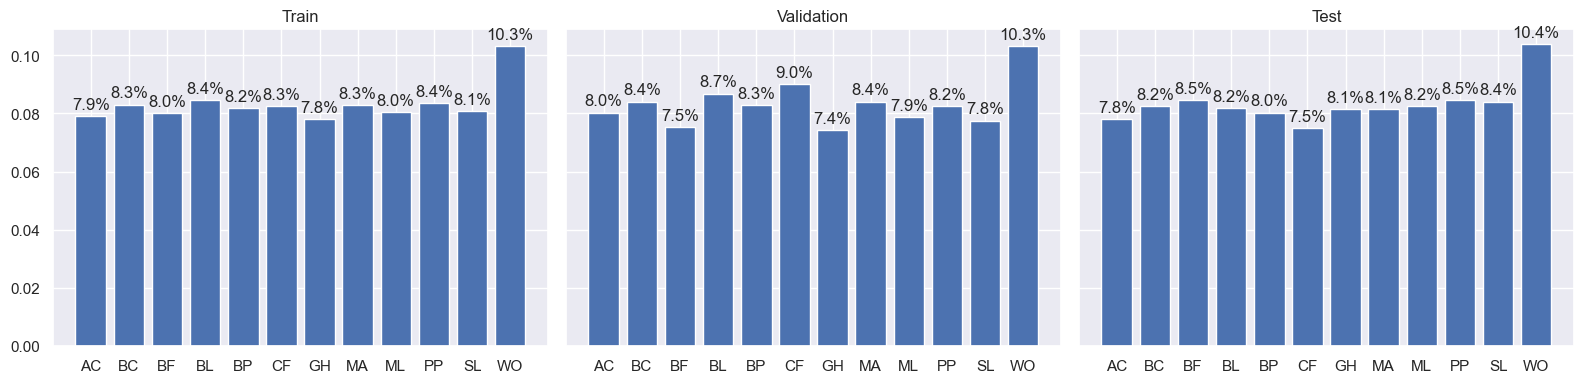

In [18]:
sns.set_theme()
dsets = {"train": trainset, "validation": valset, "test": testset}
fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True, tight_layout=True)
for (k, dset), ax in zip(dsets.items(), axs):
    vals, counts = np.unique(dset.labels, return_counts=True)
    frac = counts / len(dset)

    rects = ax.bar(list(map(lambda k: k.upper(), name_legend)), frac)
    ax.bar_label(rects, fmt="{:.1%}", padding=3)
    ax.tick_params(axis="x", labelrotation=-0)
    ax.set_title(k.capitalize())
plt.savefig(f"{fig_dir}/bn_class_balance.pdf", bbox_inches='tight')
plt.show()

In [19]:
sizes = {"train": [], "validation": []}
for k in sizes:
    dset = dsets[k]
    for item in tqdm(range(len(dset))):
        _, _, mask, _ = dset[item]
        sizes[k].append(mask.astype(bool).sum())

for k in sizes:
    sizes[k] = np.array(sizes[k])

  0%|          | 0/5492 [00:00<?, ?it/s]

  0%|          | 0/1831 [00:00<?, ?it/s]

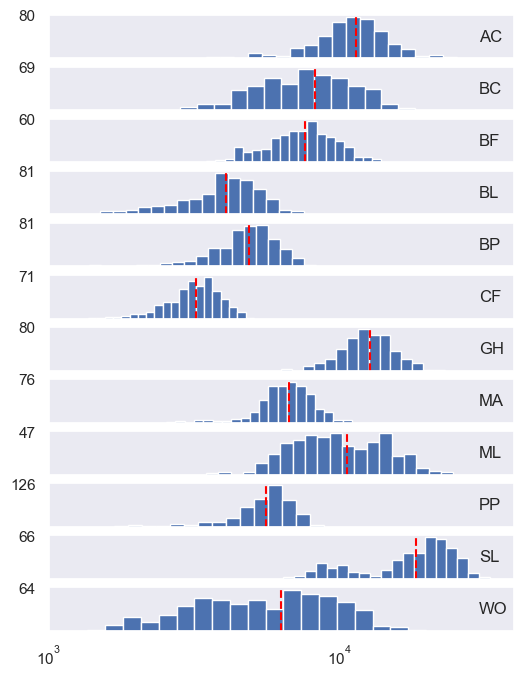

In [20]:
for k, s in sizes.items():

    fig, axs = plt.subplots(len(name_legend), 1, figsize=(6, 8), sharex=True)
    for i in range(len(name_legend)):
        # print(s[dsets[k].labels == i].mean())
        hist, bins = np.histogram(s[dsets[k].labels == i], bins=20)
        logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
        axs[i].hist(s[dsets[k].labels == i], bins=logbins)
        axs[i].axvline(s[dsets[k].labels == i].mean(), ls="--", c="red")
        axs[i].set_title(list(map(lambda k: k.upper(), name_legend.keys()))[i], x=0.925, y=0.2, loc="left")
        # axs[i].set_xticks([1e3, 5e3, 1e4, 5e4])
        axs[i].set_xlim(1e3, 4e4)
        axs[i].set_xscale("log")
        axs[i].set_yticks([int(round(v)) for v in axs[i].get_ylim()[-1:]])
        axs[i].grid(False)
    axs[5].set_ylabel('Count')
    axs[-1].set_xlabel('Size')
    plt.savefig(f"{fig_dir}/bn_size_hist.pdf", bbox_inches='tight')
    plt.show()
    break

### Samples

In [21]:
sns.reset_orig()

In [22]:
mask_comb = np.zeros((1, 128, 128, 128), dtype=bool)
for label in np.unique(trainset.labels):
    _, _, mask, _ = trainset[np.where(trainset.labels == label)[0][0]]
    mask = mask.astype(bool)
    mask_comb |= mask
# show_volume(mask_comb, size=4)

In [23]:
bbox = []
for seg in np.where(mask_comb[0]):
    bbox.append((seg.min(), seg.max()))
# show_volume(mask_comb[:, bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1], bbox[2][0]:bbox[2][1]])

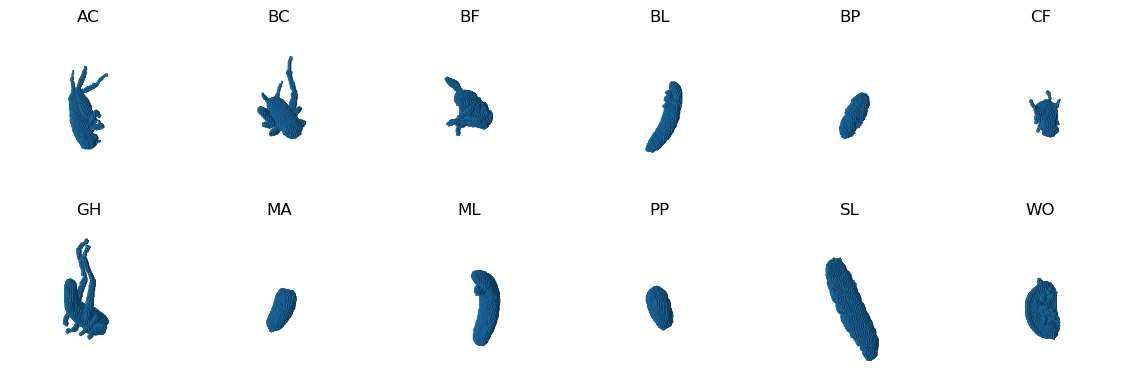

In [24]:
# fig, axs = plt.subplots(2, 6,figsize=(12,4),subplot_kw=dict(projection='3d'), tight_layout=True)
# axs = np.asarray(axs).ravel()
# for label, ax, title in zip(np.unique(trainset.labels), axs, name_legend):
#     _, _, mask, _ = trainset[np.where(trainset.labels == label)[0][0]]
#     mask = mask.astype(bool)
#     mask ^= binary_erosion(mask)
#     # ax = plt.figure().add_subplot(projection="3d")
#     ax.voxels(
#         mask.squeeze()[
#             bbox[0][0] : bbox[0][1], bbox[1][0] : bbox[1][1], bbox[2][0] : bbox[2][1]
#         ].transpose(2, 1, 0)
#     )
#     ax.set_aspect("equal")
#     ax.set_axis_off()
#     ax.set_title(title.upper())
# plt.savefig(f"{fig_dir}/bn_segmentation_samples.pdf", bbox_inches='tight')
# plt.show()

In [25]:
# ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(mask.squeeze()[:, 32:-32, 32:-32].transpose(2, 1, 0))
# ax.set_aspect('equal')
# plt.show()

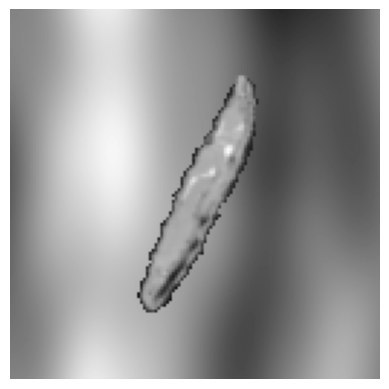

In [29]:
volume, label, mask, noise = trainset[np.where(trainset.labels == 10)[0][0]]
mask = mask.astype(bool)
slice = 65
# plt.imshow((volume).squeeze()[:, slice, :], vmin=0, vmax=255)
# plt.show()
# plt.imshow((mask).squeeze()[:, slice, :], vmin=0, vmax=255)
# plt.show()
# plt.imshow((noise).squeeze()[:, slice, :], vmin=0, vmax=255)
# plt.show()
# plt.imshow((volume * mask).squeeze()[:, slice, :], vmin=0, vmax=255)
# plt.show()
plt.imshow((volume * mask + ~mask * noise).squeeze()[:, slice, :], vmin=0, vmax=255, cmap='gray')
plt.axis(False)
# plt.savefig(f"{fig_dir}/bn_perlin_slice.pdf", bbox_inches='tight')
plt.show()

In [ ]:
# import neuroglancer

In [ ]:
# viewer = neuroglancer.Viewer()
# viewer

In [ ]:
# volume_view = neuroglancer.LocalVolume(
#     np.squeeze((mask.astype(np.uint8) * 255 + ~mask * noise)),
#     dimensions=neuroglancer.CoordinateSpace(
#         names=["x", "y", "z"],
#         units="",
#         scales=[1, 1, 1],
#     ),
# )
# with viewer.txn() as s:
#     s.layers["image"] = neuroglancer.ImageLayer(
#         source=volume_view,
#         # Define a custom shader to display this mask array as red+alpha.
#         #         shader="""
#         # void main() {
#         #   float v = toNormalized(getDataValue(0)) * 255.0;
#         #   emitRGBA(vec4(v, 0.0, 0.0, v));
#         # }
#         # """,
#     )